In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 10 #50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(3.0e3)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 3000

EPS = 1.0e-7
ALPHA = 1.0
BETA = 1.0
LAMBDA = 0.02 #0.02

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/prox_variants/')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

## Common functions

In [8]:
def forward(a, b, x):
    m = a.shape[1]
    if m == 0:
        return 0.
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T) #/ a.shape[1]

In [9]:
def compute_losses(a, b, x, y, penalized=True):
    y_hat = forward(a, b, x)
    loss_ = 0.5 * np.mean((y_hat - y)**2)
    if penalized:
        penalized_loss = loss_ + LAMBDA * np.sum(np.abs(a))
    else:
        penalized_loss = 0.
    return loss_, penalized_loss

In [10]:
def soft_thresholding(V, tau):
    return - np.sign(V) * np.maximum(0, np.abs(V) - tau)

In [11]:
def V_grad(a, b, x, y, new_b):
    y_hat = forward(a, b, x)
    if len(new_b.shape) < 2:
        new_b = new_b.reshape(1, -1)
    V_grad_ = np.mean((y_hat - y) * np.maximum(np.matmul(x, new_b.T), 0), axis=0)
    if len(V_grad_) == 1:
        return V_grad_[0]
    else:
        return V_grad_

In [12]:
def nabla_V_grad(a, b, x, y):
    n = len(x)
    y_hat = forward(a, b, x)
    M = (y_hat - y) * np.heaviside(np.matmul(x, b.T), 0)
    return np.matmul(M.T, x) / n    

In [13]:
def nabla_V_grad(a, b, x, y, factor=1.0):
    n = len(x)
    m = a.shape[1]
    y_hat = forward(a, b, x)
    # M = (y_hat - y) * np.heaviside(np.matmul(x, b.T * a), 0)
    M = (y_hat - y) * np.heaviside(np.matmul(x, b.T), 0) * factor
    return np.matmul(M.T, x) / n    

In [14]:
#def nabla_V_grad(a, b, x, y):
#    n = len(x)
#    m = a.shape[1]
#    y_hat = forward(a, b, x)
#    # M = (y_hat - y) * np.heaviside(np.matmul(x, b.T * a), 0)
#    M = (y_hat - y) * np.heaviside(np.matmul(x, b.T), 0) * a
#    return np.matmul(M.T, x) / n    

# Data

In [15]:
# Teacher Network
m_star = 50 # 500 # 50 # number of teacher neurons
eps = 3e-1

#a_star = 2 * np.sign(np.random.uniform(size=(1, m_star)) - 0.5) / np.sqrt(m_star)
a_star = 10 * np.sign(np.random.uniform(size=(1, m_star)) - 0.5)
b_star = 10 * np.random.uniform(size=(m_star, INPUT_DIM)) - 1 - eps * np.random.normal(size=(m_star, INPUT_DIM))**2

In [16]:
# Data with inputs on the sphere
x_train = np.random.normal(size=(N_TRAIN, INPUT_DIM))
train_norms = np.linalg.norm(x_train, axis=1, ord=2, keepdims=True)
x_train = x_train / train_norms
y_train = 10 *forward(a_star, b_star, x_train)

x_val = np.random.normal(size=(N_VAL, INPUT_DIM))
val_norms = np.linalg.norm(x_val, axis=1, ord=2, keepdims=True)
x_val = x_val / val_norms
y_val = 10 * forward(a_star, b_star, x_val)

In [17]:
INPUT_DIM = 10
noise = 1e-5
n_train = N_TRAIN
scale = 1.0 # 10.0

m_star = 50
a_star = np.random.normal(size=(1, m_star))
b_star = np.random.normal(size=(m_star, INPUT_DIM)) / np.sqrt(INPUT_DIM)
#b_star = np.random.normal(size=(m_star, INPUT_DIM))

n_train = 50
x_train = np.random.normal(size=(n_train, INPUT_DIM))
x_train = x_train / np.linalg.norm(x_train, axis=1, ord=2, keepdims=True)
y_train = scale * forward(a_star, b_star, x_train) / m_star + noise * np.random.normal(size=(n_train, 1))

n_val = 50
x_val = np.random.normal(size=(n_val, INPUT_DIM))
x_val = x_val / np.linalg.norm(x_val, axis=1, ord=2, keepdims=True)
y_val = scale * forward(a_star, b_star, x_val) / m_star + noise * np.random.normal(size=(n_val, 1))

In [18]:
print(np.max(np.linalg.norm(x_train, axis=1, ord=2)))
print(np.max(np.linalg.norm(x_val, axis=1, ord=2)))

1.0
1.0


We have
$$V[\mu](b) = \frac{1}{n} \sum_{i=1}^n (f(\mu;x_i) - y_i) \sigma(b^\top x_i).$$
In this setting, sampling the particles on the sphere yields
$$|V[\mu](b) - V[\nu](b)| \leq |\mu - \nu|_{TV},$$
and thus a Lipschitz constant for the gradient $V$ equal to $L=1$. 

## 0. $L^2(\tau)$ proximal algorithm: adding particles WITHOUT penalization

In [19]:
def add_new_neuron(a, b, x, y, eps=1.0e-6):
    new_b = np.random.normal(size=(1, INPUT_DIM))
    neuron_scale = np.linalg.norm(new_b, axis=1, ord=2)
    new_b = new_b / neuron_scale
    V = V_grad(a, b, x, y, new_b)
    new_a = ALPHA * soft_thresholding(V, tau=LAMBDA)
    
    if np.abs(new_a) > eps:
        if a.shape[1] == 0:
            a = np.array([[new_a]])
            b = new_b
        else:
            a = np.column_stack((a, [new_a]))
            b = np.row_stack((b, new_b))
    
    return a, b 

In [20]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    no_change_indexes = []
    
    print(N_STEPS)

    for k in tqdm(range(N_STEPS)):
        if a.shape[1] > N_MAX_NEURONS:
            print('-----  BREAKING  -----')
            break
        a, b = add_new_neuron(a, b, x_train, y_train, eps=EPS)
        ms.append(a.shape[1])
        if ms[-1] == ms[-2]:
            no_change_indexes.append(k)
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses), np.array(no_change_indexes)

In [21]:
ALPHA = 1.0
LAMBDA = 0.
n_steps = N_STEPS
a, b, ms_pure_pop, train_losses_pure_pop, penalized_train_losses_pure_pop, val_losses, penalized_val_losses, _ =\
        train(N_STEPS, x_train, y_train, x_val, y_val)

3000


  0%|                                                  | 0/3000 [00:00<?, ?it/s]

m at step 0 : 1
Train loss at step 0 : 0.00054
Validation loss at step 0 : 0.00061


  5%|█▊                                    | 139/3000 [00:00<00:02, 1389.58it/s]

m at step 100 : 101
Train loss at step 100 : 0.00034
Validation loss at step 100 : 0.00047
m at step 200 : 201
Train loss at step 200 : 0.00017
Validation loss at step 200 : 0.00033


 12%|████▍                                 | 348/3000 [00:00<00:01, 1798.52it/s]

m at step 300 : 301
Train loss at step 300 : 0.00013
Validation loss at step 300 : 0.00027
m at step 400 : 401
Train loss at step 400 : 0.00010
Validation loss at step 400 : 0.00023


 18%|██████▋                               | 528/3000 [00:00<00:01, 1503.22it/s]

m at step 500 : 501
Train loss at step 500 : 0.00008
Validation loss at step 500 : 0.00020
m at step 600 : 601
Train loss at step 600 : 0.00007
Validation loss at step 600 : 0.00018


 24%|█████████                             | 714/3000 [00:00<00:01, 1628.41it/s]

m at step 700 : 701
Train loss at step 700 : 0.00006
Validation loss at step 700 : 0.00016
m at step 800 : 801
Train loss at step 800 : 0.00006
Validation loss at step 800 : 0.00015


 29%|███████████▏                          | 882/3000 [00:00<00:01, 1482.47it/s]

m at step 900 : 901
Train loss at step 900 : 0.00005
Validation loss at step 900 : 0.00015


 34%|████████████▊                        | 1035/3000 [00:00<00:01, 1455.12it/s]

m at step 1,000 : 1,000
Train loss at step 1,000 : 0.00005
Validation loss at step 1,000 : 0.00014
m at step 1,100 : 1,100
Train loss at step 1,100 : 0.00005
Validation loss at step 1,100 : 0.00014


 39%|██████████████▌                      | 1184/3000 [00:00<00:01, 1384.63it/s]

m at step 1,200 : 1,200
Train loss at step 1,200 : 0.00005
Validation loss at step 1,200 : 0.00013


 44%|████████████████▎                    | 1325/3000 [00:00<00:01, 1210.07it/s]

m at step 1,300 : 1,300
Train loss at step 1,300 : 0.00004
Validation loss at step 1,300 : 0.00013


 48%|█████████████████▉                   | 1451/3000 [00:01<00:01, 1121.69it/s]

m at step 1,400 : 1,400
Train loss at step 1,400 : 0.00004
Validation loss at step 1,400 : 0.00012


 52%|███████████████████▎                 | 1567/3000 [00:01<00:01, 1020.47it/s]

m at step 1,500 : 1,500
Train loss at step 1,500 : 0.00004
Validation loss at step 1,500 : 0.00012
m at step 1,600 : 1,600
Train loss at step 1,600 : 0.00004
Validation loss at step 1,600 : 0.00012


 60%|██████████████████████               | 1790/3000 [00:01<00:01, 1020.82it/s]

m at step 1,700 : 1,700
Train loss at step 1,700 : 0.00004
Validation loss at step 1,700 : 0.00011
m at step 1,800 : 1,800
Train loss at step 1,800 : 0.00003
Validation loss at step 1,800 : 0.00011


 63%|███████████████████████▎             | 1895/3000 [00:01<00:01, 1015.65it/s]

m at step 1,900 : 1,900
Train loss at step 1,900 : 0.00003
Validation loss at step 1,900 : 0.00011


 67%|█████████████████████████▎            | 1999/3000 [00:01<00:01, 940.84it/s]

m at step 2,000 : 1,999
Train loss at step 2,000 : 0.00003
Validation loss at step 2,000 : 0.00011


 70%|██████████████████████████▌           | 2095/3000 [00:01<00:01, 897.56it/s]

m at step 2,100 : 2,099
Train loss at step 2,100 : 0.00003
Validation loss at step 2,100 : 0.00011


 73%|███████████████████████████▋          | 2186/3000 [00:01<00:01, 800.73it/s]

m at step 2,200 : 2,199
Train loss at step 2,200 : 0.00003
Validation loss at step 2,200 : 0.00010


 79%|██████████████████████████████▏       | 2380/3000 [00:02<00:00, 853.36it/s]

m at step 2,300 : 2,299
Train loss at step 2,300 : 0.00003
Validation loss at step 2,300 : 0.00010


 82%|███████████████████████████████▎      | 2468/3000 [00:02<00:00, 846.92it/s]

m at step 2,400 : 2,399
Train loss at step 2,400 : 0.00003
Validation loss at step 2,400 : 0.00010


 85%|████████████████████████████████▍     | 2556/3000 [00:02<00:00, 855.35it/s]

m at step 2,500 : 2,499
Train loss at step 2,500 : 0.00003
Validation loss at step 2,500 : 0.00010


 88%|█████████████████████████████████▍    | 2644/3000 [00:02<00:00, 859.24it/s]

m at step 2,600 : 2,599
Train loss at step 2,600 : 0.00003
Validation loss at step 2,600 : 0.00010


 91%|██████████████████████████████████▌   | 2731/3000 [00:02<00:00, 854.64it/s]

m at step 2,700 : 2,699
Train loss at step 2,700 : 0.00002
Validation loss at step 2,700 : 0.00010


 94%|███████████████████████████████████▋  | 2818/3000 [00:02<00:00, 851.13it/s]

m at step 2,800 : 2,798
Train loss at step 2,800 : 0.00002
Validation loss at step 2,800 : 0.00010


 97%|████████████████████████████████████▊ | 2904/3000 [00:02<00:00, 829.46it/s]

m at step 2,900 : 2,898
Train loss at step 2,900 : 0.00002
Validation loss at step 2,900 : 0.00009


100%|█████████████████████████████████████| 3000/3000 [00:02<00:00, 1018.36it/s]


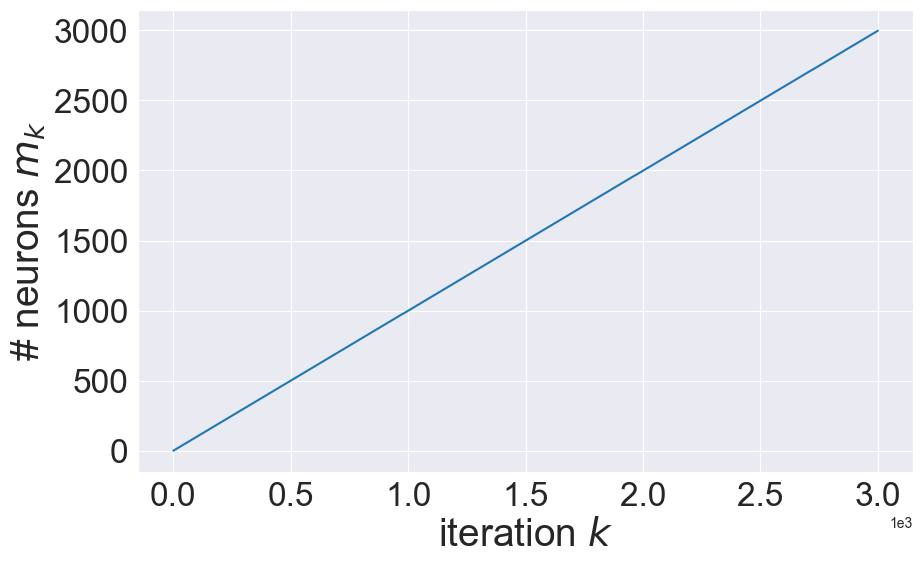

In [22]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms_pure_pop)), ms_pure_pop, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

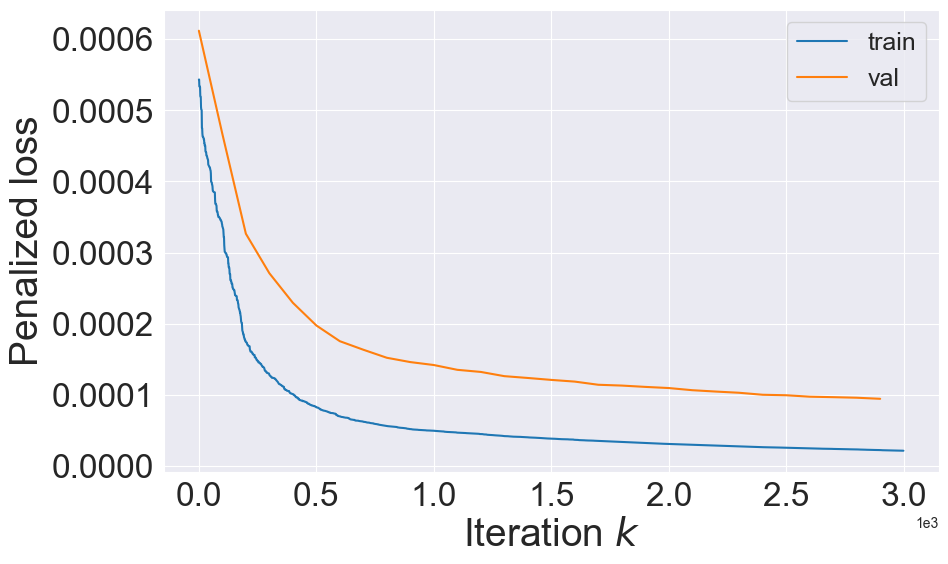

In [23]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_pure_pop)), penalized_train_losses_pure_pop, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_pure_pop)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

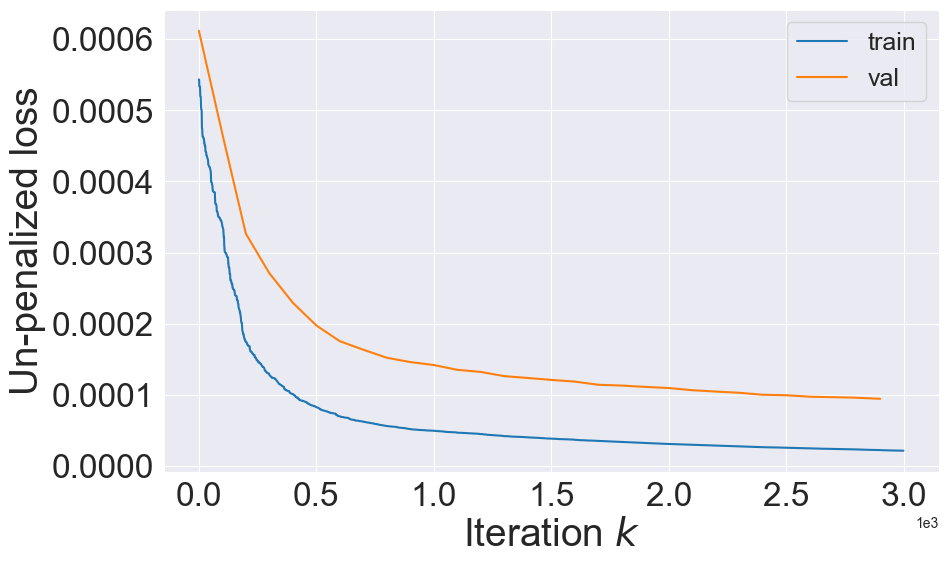

In [24]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_pure_pop)), train_losses_pure_pop, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_pure_pop)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 1. $L^2(\tau)$ proximal algorithm: adding particles

In [25]:
def add_new_neuron(a, b, x, y, eps=1.0e-6):
    new_b = np.random.normal(size=(1, INPUT_DIM))
    neuron_scale = np.linalg.norm(new_b, axis=1, ord=2)
    new_b = new_b / neuron_scale
    V = V_grad(a, b, x, y, new_b)
    new_a = ALPHA * soft_thresholding(V, tau=LAMBDA)
    
    if np.abs(new_a) > eps:
        if a.shape[1] == 0:
            a = np.array([[new_a]])
            b = new_b
        else:
            a = np.column_stack((a, [new_a]))
            b = np.row_stack((b, new_b))
    
    return a, b 

In [26]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    no_change_indexes = []

    for k in tqdm(range(N_STEPS)):
        if a.shape[1] > N_MAX_NEURONS:
            print('-----  BREAKING  -----')
            break
        a, b = add_new_neuron(a, b, x_train, y_train, eps=EPS)
        ms.append(a.shape[1])
        if ms[-1] == ms[-2]:
            no_change_indexes.append(k)
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses), np.array(no_change_indexes)

In [27]:
LAMBDA = 0.0007 # 0.001
a, b, ms_pop, train_losses_pop, penalized_train_losses_pop, val_losses, penalized_val_losses, no_change_indexes = \
        train(N_STEPS, x_train, y_train, x_val, y_val)

 18%|██████▋                               | 526/3000 [00:00<00:00, 5253.38it/s]

m at step 0 : 0
Train loss at step 0 : 0.00055
Validation loss at step 0 : 0.00062
m at step 100 : 71
Train loss at step 100 : 0.00033
Validation loss at step 100 : 0.00047
m at step 200 : 129
Train loss at step 200 : 0.00024
Validation loss at step 200 : 0.00038
m at step 300 : 175
Train loss at step 300 : 0.00018
Validation loss at step 300 : 0.00032
m at step 400 : 222
Train loss at step 400 : 0.00015
Validation loss at step 400 : 0.00029
m at step 500 : 254
Train loss at step 500 : 0.00014
Validation loss at step 500 : 0.00027
m at step 600 : 292
Train loss at step 600 : 0.00012
Validation loss at step 600 : 0.00026
m at step 700 : 325
Train loss at step 700 : 0.00011
Validation loss at step 700 : 0.00025
m at step 800 : 347
Train loss at step 800 : 0.00010
Validation loss at step 800 : 0.00024
m at step 900 : 371
Train loss at step 900 : 0.00010
Validation loss at step 900 : 0.00023
m at step 1,000 : 382
Train loss at step 1,000 : 0.00010
Validation loss at step 1,000 : 0.00023


 51%|██████████████████▊                  | 1528/3000 [00:00<00:00, 3992.25it/s]

m at step 1,100 : 395
Train loss at step 1,100 : 0.00009
Validation loss at step 1,100 : 0.00022
m at step 1,200 : 409
Train loss at step 1,200 : 0.00009
Validation loss at step 1,200 : 0.00022
m at step 1,300 : 423
Train loss at step 1,300 : 0.00009
Validation loss at step 1,300 : 0.00022
m at step 1,400 : 434
Train loss at step 1,400 : 0.00008
Validation loss at step 1,400 : 0.00021
m at step 1,500 : 448
Train loss at step 1,500 : 0.00008
Validation loss at step 1,500 : 0.00021
m at step 1,600 : 458
Train loss at step 1,600 : 0.00008
Validation loss at step 1,600 : 0.00021
m at step 1,700 : 467
Train loss at step 1,700 : 0.00008
Validation loss at step 1,700 : 0.00021
m at step 1,800 : 477
Train loss at step 1,800 : 0.00008
Validation loss at step 1,800 : 0.00021


 78%|████████████████████████████▊        | 2335/3000 [00:00<00:00, 3559.81it/s]

m at step 1,900 : 486
Train loss at step 1,900 : 0.00008
Validation loss at step 1,900 : 0.00020
m at step 2,000 : 496
Train loss at step 2,000 : 0.00008
Validation loss at step 2,000 : 0.00020
m at step 2,100 : 508
Train loss at step 2,100 : 0.00008
Validation loss at step 2,100 : 0.00020
m at step 2,200 : 512
Train loss at step 2,200 : 0.00007
Validation loss at step 2,200 : 0.00020
m at step 2,300 : 519
Train loss at step 2,300 : 0.00007
Validation loss at step 2,300 : 0.00020
m at step 2,400 : 525
Train loss at step 2,400 : 0.00007
Validation loss at step 2,400 : 0.00020
m at step 2,500 : 531
Train loss at step 2,500 : 0.00007
Validation loss at step 2,500 : 0.00020


100%|█████████████████████████████████████| 3000/3000 [00:00<00:00, 3712.11it/s]

m at step 2,600 : 535
Train loss at step 2,600 : 0.00007
Validation loss at step 2,600 : 0.00020
m at step 2,700 : 542
Train loss at step 2,700 : 0.00007
Validation loss at step 2,700 : 0.00020
m at step 2,800 : 545
Train loss at step 2,800 : 0.00007
Validation loss at step 2,800 : 0.00020
m at step 2,900 : 551
Train loss at step 2,900 : 0.00007
Validation loss at step 2,900 : 0.00020


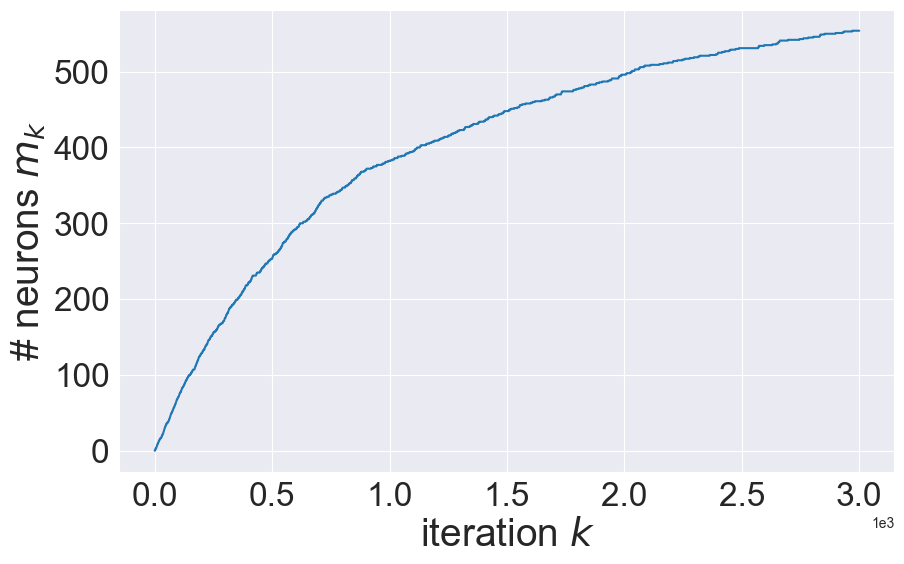

In [28]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms_pop)), ms_pop, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

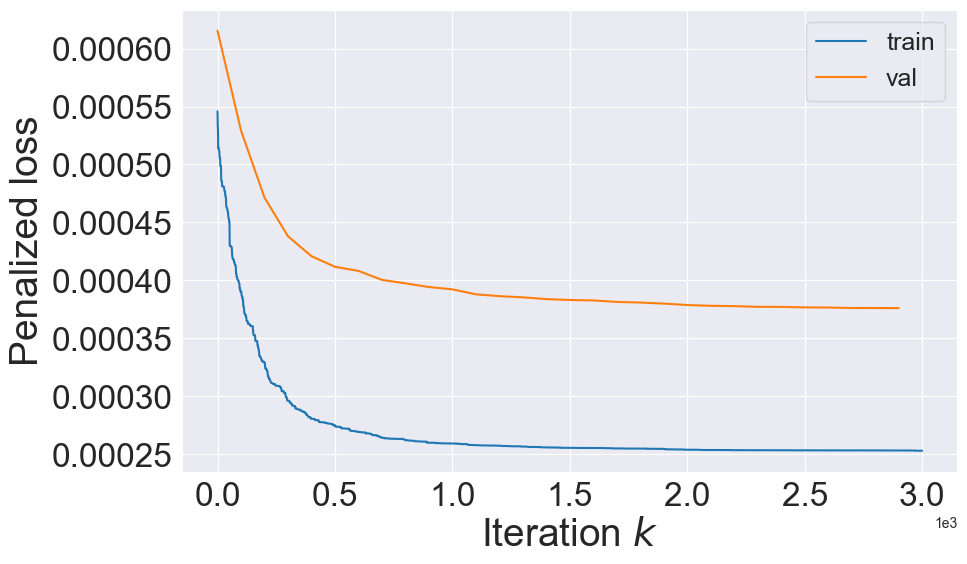

In [29]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_pop)), penalized_train_losses_pop, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_pop)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

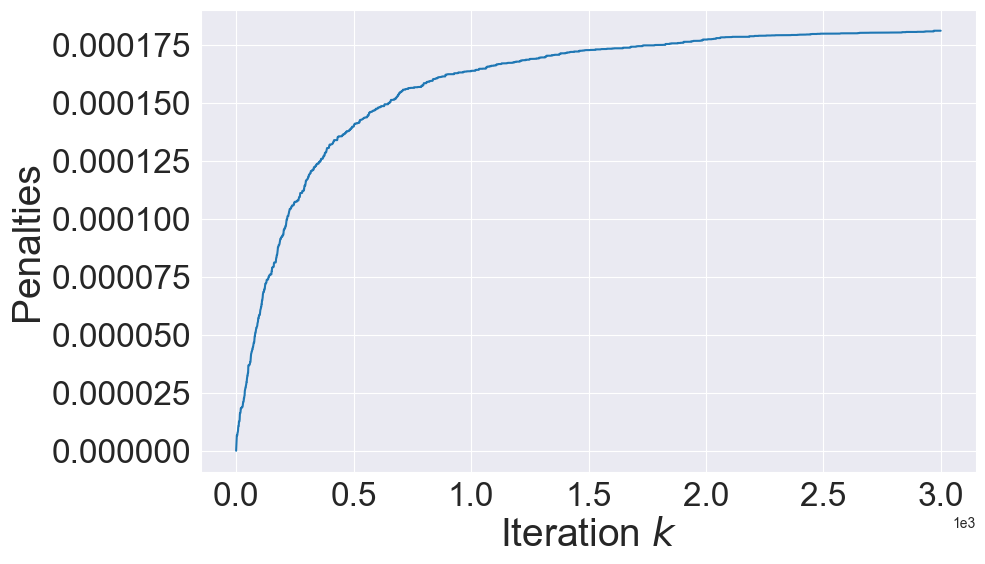

In [30]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_pop - train_losses_pop

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

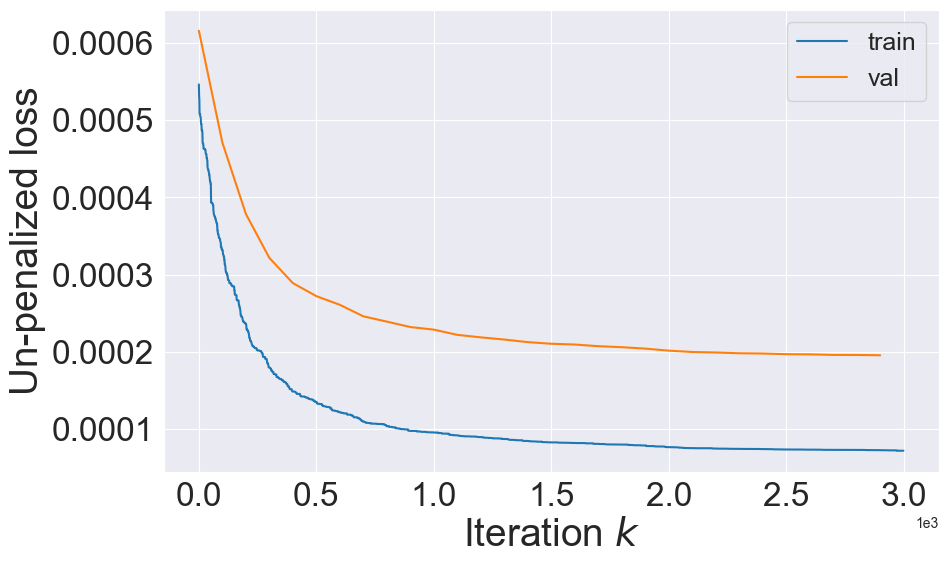

In [31]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_pop)), train_losses_pop, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_pop)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 2. $L^2(\tau_m)$ proximal algorithm

Here we sample $m$ neurons $(b_1, \ldots, b_m)$ on the sphere and update their weights via finite-dimensional coordinate descent through the following correspondance:
\begin{align*}
    \mu_a &= \sum_{j=1}^m a_j \delta_{b_j}\\
    f(a) &= J(\mu_a) \\
    g(a) &= \lambda ||a||_1 \\
    F_m(a) &= F(\mu_a) = f(a) +  \lambda ||a||_1\\
    \nabla_j f(a) &= V[\mu_a](b_j) \\
\end{align*}
And $f$ is $L m$-Lipschitz. 

From the $L$-Lipschitzness of $V$ we know that for any $a, b, t$
\begin{align*}
    F_m(a + te_j) = F(\mu_a + t \delta_{b_j}) \leq F_m(a) + V[\mu_a](b_j) t + \frac{L}{2}t^2 + \lambda|t+a_j| - \lambda |a_j|
\end{align*}
In pratice, we do not always have access to the value of $L$, so we choose a step-size $\beta \in (0,1)$, and we have
\begin{align*}
    F_m(a + \beta te_j) \leq F_m(a) + \beta \left[V[\mu_a](b_j) t + \frac{\beta L}{2}t^2 + \lambda\left|t+\frac{a_j}{\beta} \right| \right] - \lambda |a_j|,
\end{align*}
and thus, as soon as $\beta \leq 1/L$ we can virtually replace the initial $L$ by $1$ and $a_j$ by $a_j / \beta$ since
\begin{align*}
    F_m(a + \beta te_j) \leq F_m(a) + \beta \left[V[\mu_a](b_j) t + \frac{t^2}{2} + \lambda\left|t+\frac{a_j}{\beta} \right| \right] - \lambda |a_j|.
\end{align*}
The update for the sampled coordinate $j$ thus reads
\begin{align*}
    a_j &\leftarrow a_j + \beta t_j^* \\
    t_j^* :&= \text{argmin}_{t} \left(V[\mu_a](b_j) t + \frac{t^2}{2} + \lambda\left|t+\frac{a_j}{\beta} \right| \right) = -\frac{a_j}{\beta} - \text{sign}\left(V[\mu_a](b_j) - \frac{a_j}{\beta} \right) \max \left(0, \left|V[\mu_a](b_j) - \frac{a_j}{\beta} \right| - \lambda \right),
\end{align*}
which gives 
\begin{align*}
    a_j &\leftarrow - \beta \text{sign}\left(V[\mu_a](b_j) - \frac{a_j}{\beta} \right) \max \left(0, \left|V[\mu_a](b_j) - \frac{a_j}{\beta} \right| - \lambda \right)
\end{align*}

In [32]:
n_steps = N_STEPS
m = 500
BETA = 1.0

In [33]:
def update_random_neuron(m, a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=m)
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)
        a[0, j] = new_a  

        #if np.abs(new_a) > eps:
            # update weight for neuron b_j
        #    a[0, j] = new_a  
        #else:
            # remove a_j and b_j from the list
            # a = np.column_stack((a[:, :j], a[:, j+1:]))
            # b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [34]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.zeros(shape=(1, m))
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    b_0 = np.copy(b)
    
    ms = [m]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    where_decrease_indexes = []

    for k in tqdm(range(N_STEPS)):
        a, b = update_random_neuron(m, a, b, x_train, y_train, eps=1e-9)
        ms.append(a.shape[1])
        if ms[-1] == ms[-2]-1:
            where_decrease_indexes.append(k)
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, b_0, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses), np.array(where_decrease_indexes)

In [35]:
a, b, b_0, ms_coord, train_losses_coord, penalized_train_losses_coord, val_losses, penalized_val_losses, \
    where_decrease_indexes = train(m, n_steps, x_train, y_train, x_val, y_val)

  4%|█▌                                     | 122/3000 [00:00<00:04, 703.56it/s]

m at step 0 : 500
Train loss at step 0 : 0.00053
Validation loss at step 0 : 0.00060
m at step 100 : 500
Train loss at step 100 : 0.00035
Validation loss at step 100 : 0.00049


 27%|██████████▍                           | 821/3000 [00:00<00:00, 2660.76it/s]

m at step 200 : 500
Train loss at step 200 : 0.00026
Validation loss at step 200 : 0.00042
m at step 300 : 500
Train loss at step 300 : 0.00020
Validation loss at step 300 : 0.00036
m at step 400 : 500
Train loss at step 400 : 0.00018
Validation loss at step 400 : 0.00034
m at step 500 : 500
Train loss at step 500 : 0.00016
Validation loss at step 500 : 0.00030
m at step 600 : 500
Train loss at step 600 : 0.00015
Validation loss at step 600 : 0.00029
m at step 700 : 500
Train loss at step 700 : 0.00014
Validation loss at step 700 : 0.00028
m at step 800 : 500
Train loss at step 800 : 0.00013
Validation loss at step 800 : 0.00027
m at step 900 : 500
Train loss at step 900 : 0.00012
Validation loss at step 900 : 0.00026
m at step 1,000 : 500
Train loss at step 1,000 : 0.00011
Validation loss at step 1,000 : 0.00025


 55%|████████████████████▍                | 1657/3000 [00:00<00:00, 3553.61it/s]

m at step 1,100 : 500
Train loss at step 1,100 : 0.00010
Validation loss at step 1,100 : 0.00024
m at step 1,200 : 500
Train loss at step 1,200 : 0.00010
Validation loss at step 1,200 : 0.00024
m at step 1,300 : 500
Train loss at step 1,300 : 0.00010
Validation loss at step 1,300 : 0.00023
m at step 1,400 : 500
Train loss at step 1,400 : 0.00010
Validation loss at step 1,400 : 0.00023
m at step 1,500 : 500
Train loss at step 1,500 : 0.00009
Validation loss at step 1,500 : 0.00023
m at step 1,600 : 500
Train loss at step 1,600 : 0.00009
Validation loss at step 1,600 : 0.00023
m at step 1,700 : 500
Train loss at step 1,700 : 0.00009
Validation loss at step 1,700 : 0.00022
m at step 1,800 : 500
Train loss at step 1,800 : 0.00009
Validation loss at step 1,800 : 0.00022
m at step 1,900 : 500
Train loss at step 1,900 : 0.00009
Validation loss at step 1,900 : 0.00022


 81%|█████████████████████████████▉       | 2429/3000 [00:00<00:00, 3212.09it/s]

m at step 2,000 : 500
Train loss at step 2,000 : 0.00009
Validation loss at step 2,000 : 0.00022
m at step 2,100 : 500
Train loss at step 2,100 : 0.00009
Validation loss at step 2,100 : 0.00022
m at step 2,200 : 500
Train loss at step 2,200 : 0.00009
Validation loss at step 2,200 : 0.00022
m at step 2,300 : 500
Train loss at step 2,300 : 0.00009
Validation loss at step 2,300 : 0.00021
m at step 2,400 : 500
Train loss at step 2,400 : 0.00008
Validation loss at step 2,400 : 0.00021
m at step 2,500 : 500
Train loss at step 2,500 : 0.00009
Validation loss at step 2,500 : 0.00021


100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 2875.57it/s]

m at step 2,600 : 500
Train loss at step 2,600 : 0.00008
Validation loss at step 2,600 : 0.00021
m at step 2,700 : 500
Train loss at step 2,700 : 0.00008
Validation loss at step 2,700 : 0.00021
m at step 2,800 : 500
Train loss at step 2,800 : 0.00008
Validation loss at step 2,800 : 0.00021
m at step 2,900 : 500
Train loss at step 2,900 : 0.00008
Validation loss at step 2,900 : 0.00021


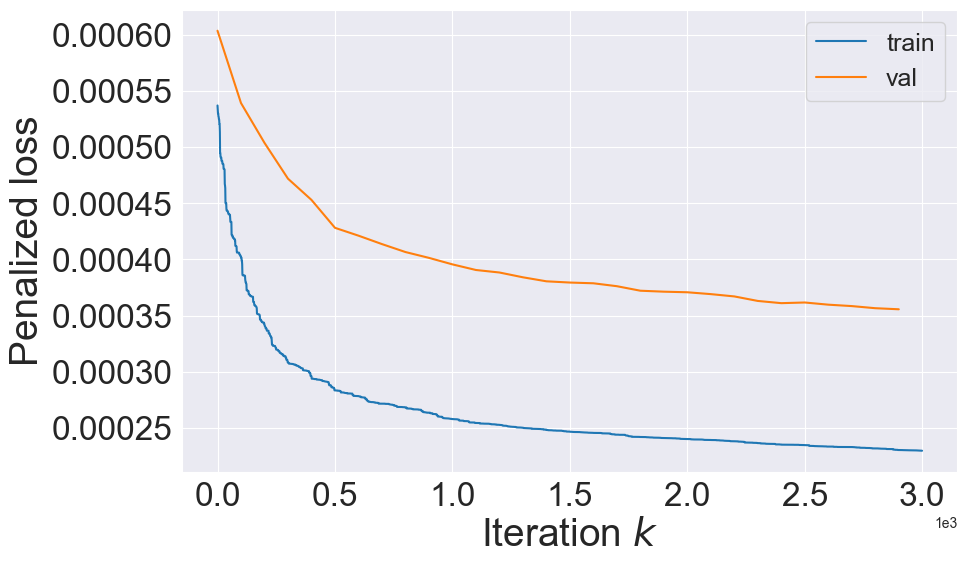

In [36]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_coord)), penalized_train_losses_coord, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_coord)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

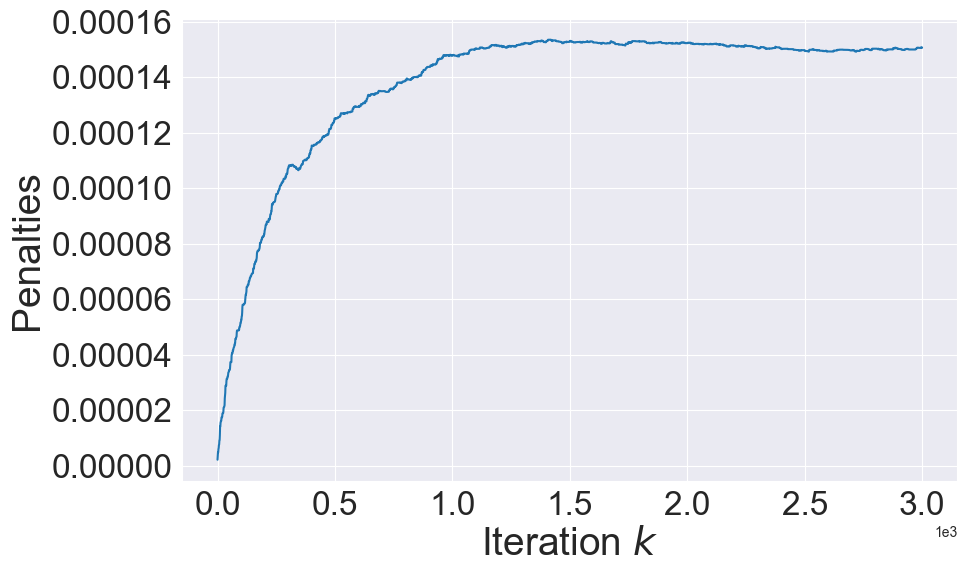

In [37]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_coord - train_losses_coord

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

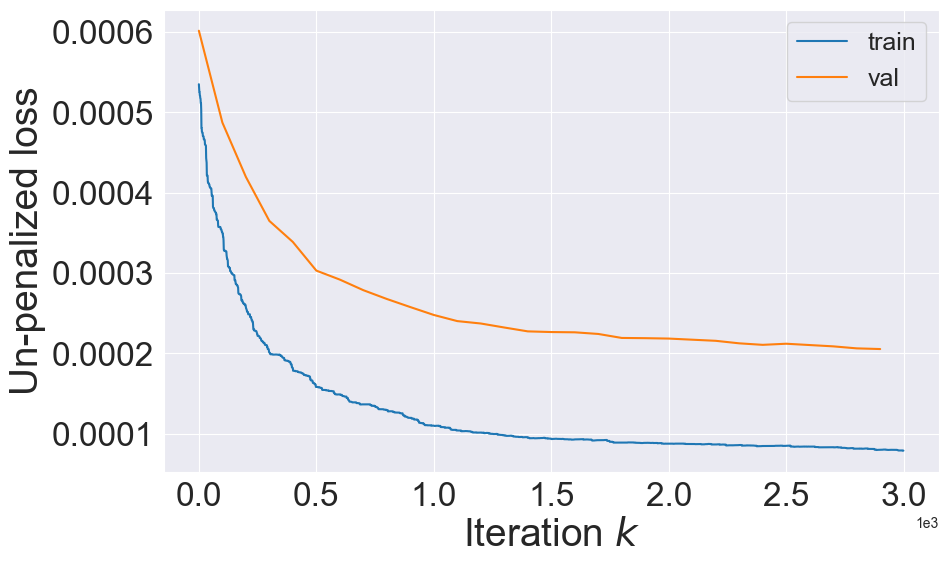

In [38]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_coord)), train_losses_coord, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_coord)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 3. Projected conic descent

In [39]:
n_steps = N_STEPS
m = 500
ETA = 0.05
penalized = False

In [40]:
def projected_conic_particle_update(a, b, x, y, penalized=False):
    m = a.shape[1]
    if m > 0:
        signs = np.sign(a)
        a = a * (1 - 2 * ETA * signs * V_grad(a, b, x, y, b).reshape(1, -1))
        b = b - ETA * signs.T * nabla_V_grad(a, b, x, y)
        
        if penalized:
            a -= 2 * ETA * LAMBDA * a
            b -= ETA * LAMBDA * b
        
        b_norms = np.linalg.norm(b, ord=2, axis=1, keepdims=True)
        b = b / b_norms
    return a, b  

In [41]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True, penalized=False):
    #a = np.zeros(shape=(1, m))
    a = np.random.normal(size=(1, m)) / m
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    ms = [m]

    for k in tqdm(range(n_steps)):
        a, b = projected_conic_particle_update(a, b, x_train, y_train, penalized=penalized)
        ms.append(a.shape[1])
        
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [42]:
a, b, ms_conic, train_losses_conic, penalized_train_losses_conic, val_losses_conic, penalized_val_losses_conic = \
    train(m, n_steps, x_train, y_train, x_val, y_val, penalized=penalized)

  3%|█▏                                      | 90/3000 [00:00<00:03, 892.92it/s]

m at step 0 : 500
Train loss at step 0 : 0.00067
Validation loss at step 0 : 0.00063
m at step 100 : 500
Train loss at step 100 : 0.00050
Validation loss at step 100 : 0.00052


 12%|████▌                                  | 351/3000 [00:00<00:03, 838.80it/s]

m at step 200 : 500
Train loss at step 200 : 0.00038
Validation loss at step 200 : 0.00044
m at step 300 : 500
Train loss at step 300 : 0.00029
Validation loss at step 300 : 0.00038


 17%|██████▋                                | 519/3000 [00:00<00:03, 804.28it/s]

m at step 400 : 500
Train loss at step 400 : 0.00023
Validation loss at step 400 : 0.00033
m at step 500 : 500
Train loss at step 500 : 0.00018
Validation loss at step 500 : 0.00029


 23%|████████▉                              | 684/3000 [00:00<00:02, 791.11it/s]

m at step 600 : 500
Train loss at step 600 : 0.00015
Validation loss at step 600 : 0.00026
m at step 700 : 500
Train loss at step 700 : 0.00012
Validation loss at step 700 : 0.00024


 33%|████████████▋                          | 978/3000 [00:01<00:02, 935.27it/s]

m at step 800 : 500
Train loss at step 800 : 0.00010
Validation loss at step 800 : 0.00022
m at step 900 : 500
Train loss at step 900 : 0.00009
Validation loss at step 900 : 0.00020
m at step 1,000 : 500
Train loss at step 1,000 : 0.00008
Validation loss at step 1,000 : 0.00019


 43%|███████████████▉                     | 1297/3000 [00:01<00:01, 1023.99it/s]

m at step 1,100 : 500
Train loss at step 1,100 : 0.00007
Validation loss at step 1,100 : 0.00018
m at step 1,200 : 500
Train loss at step 1,200 : 0.00006
Validation loss at step 1,200 : 0.00017
m at step 1,300 : 500
Train loss at step 1,300 : 0.00006
Validation loss at step 1,300 : 0.00016


 52%|███████████████████▏                 | 1554/3000 [00:01<00:01, 1163.49it/s]

m at step 1,400 : 500
Train loss at step 1,400 : 0.00005
Validation loss at step 1,400 : 0.00016
m at step 1,500 : 500
Train loss at step 1,500 : 0.00005
Validation loss at step 1,500 : 0.00015
m at step 1,600 : 500
Train loss at step 1,600 : 0.00004
Validation loss at step 1,600 : 0.00015


 65%|████████████████████████▏            | 1963/3000 [00:01<00:00, 1289.10it/s]

m at step 1,700 : 500
Train loss at step 1,700 : 0.00004
Validation loss at step 1,700 : 0.00014
m at step 1,800 : 500
Train loss at step 1,800 : 0.00004
Validation loss at step 1,800 : 0.00014
m at step 1,900 : 500
Train loss at step 1,900 : 0.00004
Validation loss at step 1,900 : 0.00014


 74%|███████████████████████████▎         | 2217/3000 [00:02<00:00, 1238.26it/s]

m at step 2,000 : 500
Train loss at step 2,000 : 0.00003
Validation loss at step 2,000 : 0.00013
m at step 2,100 : 500
Train loss at step 2,100 : 0.00003
Validation loss at step 2,100 : 0.00013
m at step 2,200 : 500
Train loss at step 2,200 : 0.00003
Validation loss at step 2,200 : 0.00013


 82%|██████████████████████████████▍      | 2466/3000 [00:02<00:00, 1142.79it/s]

m at step 2,300 : 500
Train loss at step 2,300 : 0.00003
Validation loss at step 2,300 : 0.00013
m at step 2,400 : 500
Train loss at step 2,400 : 0.00003
Validation loss at step 2,400 : 0.00012


 86%|███████████████████████████████▊     | 2582/3000 [00:02<00:00, 1017.70it/s]

m at step 2,500 : 500
Train loss at step 2,500 : 0.00003
Validation loss at step 2,500 : 0.00012
m at step 2,600 : 500
Train loss at step 2,600 : 0.00002
Validation loss at step 2,600 : 0.00012


 93%|███████████████████████████████████▎  | 2787/3000 [00:02<00:00, 939.97it/s]

m at step 2,700 : 500
Train loss at step 2,700 : 0.00002
Validation loss at step 2,700 : 0.00012
m at step 2,800 : 500
Train loss at step 2,800 : 0.00002
Validation loss at step 2,800 : 0.00012


100%|██████████████████████████████████████| 3000/3000 [00:03<00:00, 994.23it/s]

m at step 2,900 : 500
Train loss at step 2,900 : 0.00002
Validation loss at step 2,900 : 0.00011


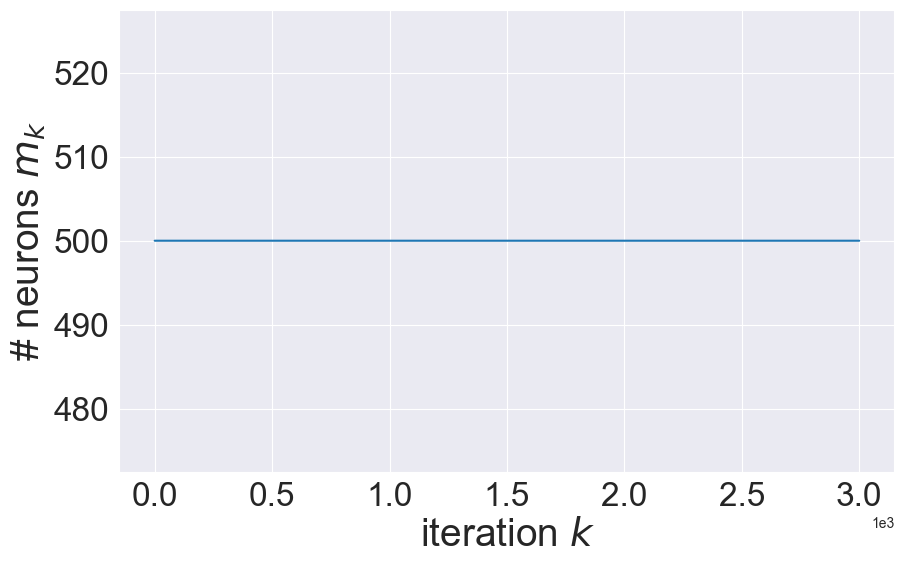

In [43]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms_conic)), ms_conic, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

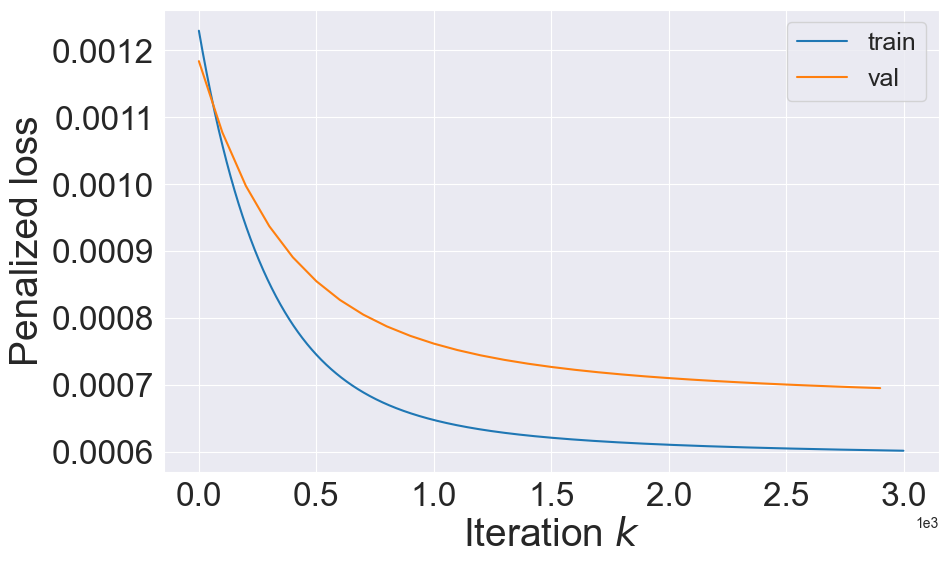

In [44]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_conic)), penalized_train_losses_conic, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_conic)) for k in range(len(penalized_val_losses_conic))], 
         penalized_val_losses_conic, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

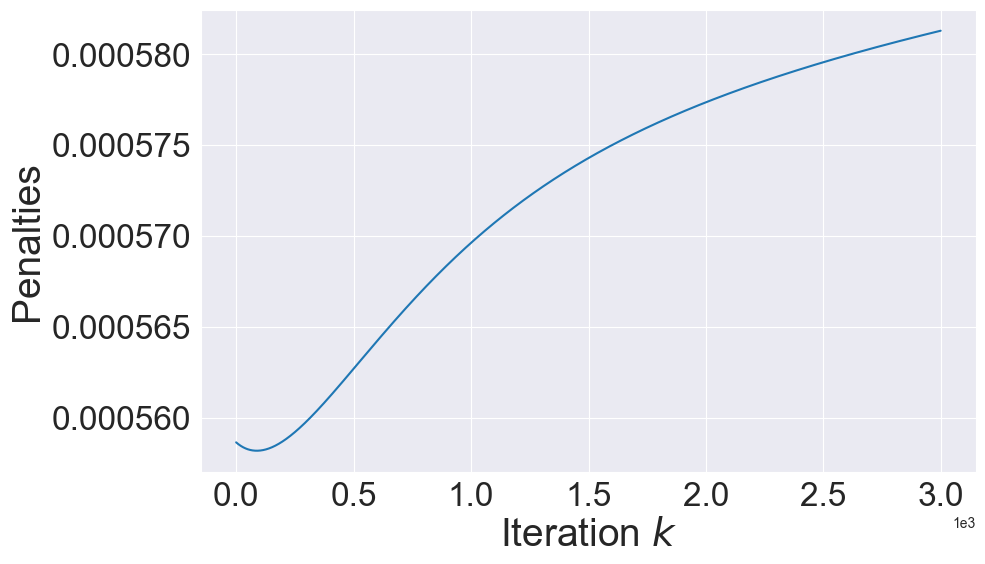

In [45]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_conic - train_losses_conic

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

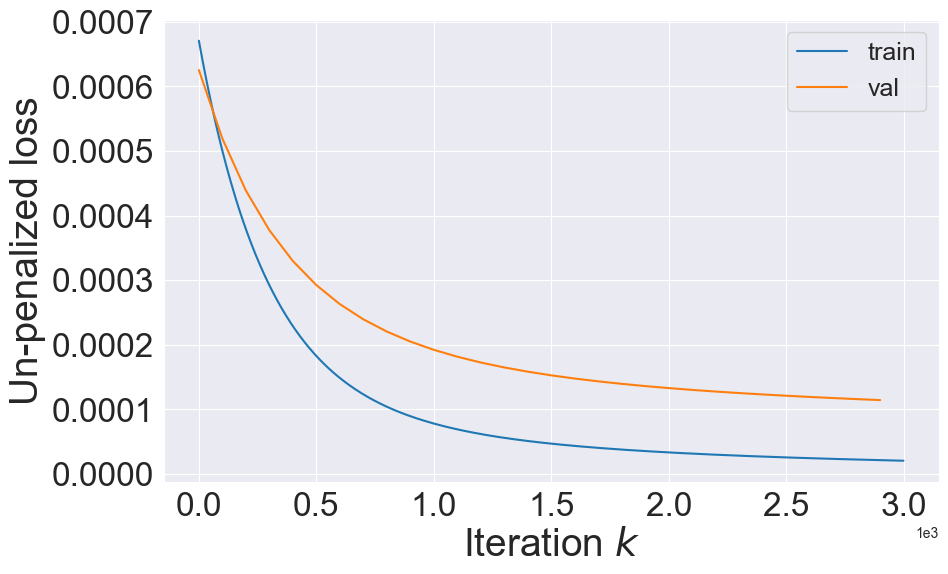

In [46]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_conic)), train_losses_conic, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_conic)) for k in range(len(val_losses_conic))], val_losses_conic,
         label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 4. Mix $L^2(\tau)/L^2(\tau_m)$ proximal algorithm

Here we mix one step of sampling a new particle and adjusting its weight and one step of chosing an existing particle at random and updating its weight. 

In [47]:
n_steps = N_STEPS
m = 500
ALPHA = 1.0
BETA = 1.0

In [48]:
def update_random_neuron(a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=a.shape[1])
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)

        if np.abs(new_a) > 0:
            # update weight for neuron b_j
            a[0, j] = new_a  
        else:
            # remove a_j and b_j from the list
            a = np.column_stack((a[:, :j], a[:, j+1:]))
            b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [49]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []

    for k in tqdm(range(n_steps)):
        if k % 2 == 0:
            # sample new particle and set weight
            a, b = add_new_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        else:
            # update existing particle
            a, b = update_random_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [50]:
a, b, ms_mix, train_losses_mix, penalized_train_losses_mix, val_losses, penalized_val_losses = \
        train(n_steps, x_train, y_train, x_val, y_val)

 25%|█████████▌                            | 757/3000 [00:00<00:00, 7568.80it/s]

m at step 0 : 1
Train loss at step 0 : 0.00054
Validation loss at step 0 : 0.00062
m at step 100 : 36
Train loss at step 100 : 0.00030
Validation loss at step 100 : 0.00047
m at step 200 : 58
Train loss at step 200 : 0.00021
Validation loss at step 200 : 0.00039
m at step 300 : 85
Train loss at step 300 : 0.00017
Validation loss at step 300 : 0.00033
m at step 400 : 103
Train loss at step 400 : 0.00014
Validation loss at step 400 : 0.00030
m at step 500 : 116
Train loss at step 500 : 0.00013
Validation loss at step 500 : 0.00028
m at step 600 : 122
Train loss at step 600 : 0.00012
Validation loss at step 600 : 0.00027
m at step 700 : 122
Train loss at step 700 : 0.00011
Validation loss at step 700 : 0.00026
m at step 800 : 123
Train loss at step 800 : 0.00011
Validation loss at step 800 : 0.00025
m at step 900 : 128
Train loss at step 900 : 0.00010
Validation loss at step 900 : 0.00024
m at step 1,000 : 130
Train loss at step 1,000 : 0.00010
Validation loss at step 1,000 : 0.00023
m at

 73%|███████████████████████████          | 2192/3000 [00:00<00:00, 6454.58it/s]

m at step 1,500 : 147
Train loss at step 1,500 : 0.00009
Validation loss at step 1,500 : 0.00022
m at step 1,600 : 150
Train loss at step 1,600 : 0.00009
Validation loss at step 1,600 : 0.00021
m at step 1,700 : 146
Train loss at step 1,700 : 0.00009
Validation loss at step 1,700 : 0.00021
m at step 1,800 : 151
Train loss at step 1,800 : 0.00009
Validation loss at step 1,800 : 0.00021
m at step 1,900 : 146
Train loss at step 1,900 : 0.00008
Validation loss at step 1,900 : 0.00021
m at step 2,000 : 147
Train loss at step 2,000 : 0.00008
Validation loss at step 2,000 : 0.00021
m at step 2,100 : 144
Train loss at step 2,100 : 0.00008
Validation loss at step 2,100 : 0.00021
m at step 2,200 : 142
Train loss at step 2,200 : 0.00008
Validation loss at step 2,200 : 0.00020
m at step 2,300 : 143
Train loss at step 2,300 : 0.00008
Validation loss at step 2,300 : 0.00021
m at step 2,400 : 147
Train loss at step 2,400 : 0.00008
Validation loss at step 2,400 : 0.00020
m at step 2,500 : 148
Train lo

100%|█████████████████████████████████████| 3000/3000 [00:00<00:00, 5940.56it/s]

m at step 2,600 : 148
Train loss at step 2,600 : 0.00008
Validation loss at step 2,600 : 0.00019
m at step 2,700 : 147
Train loss at step 2,700 : 0.00008
Validation loss at step 2,700 : 0.00019
m at step 2,800 : 146
Train loss at step 2,800 : 0.00008
Validation loss at step 2,800 : 0.00019
m at step 2,900 : 147
Train loss at step 2,900 : 0.00008
Validation loss at step 2,900 : 0.00019


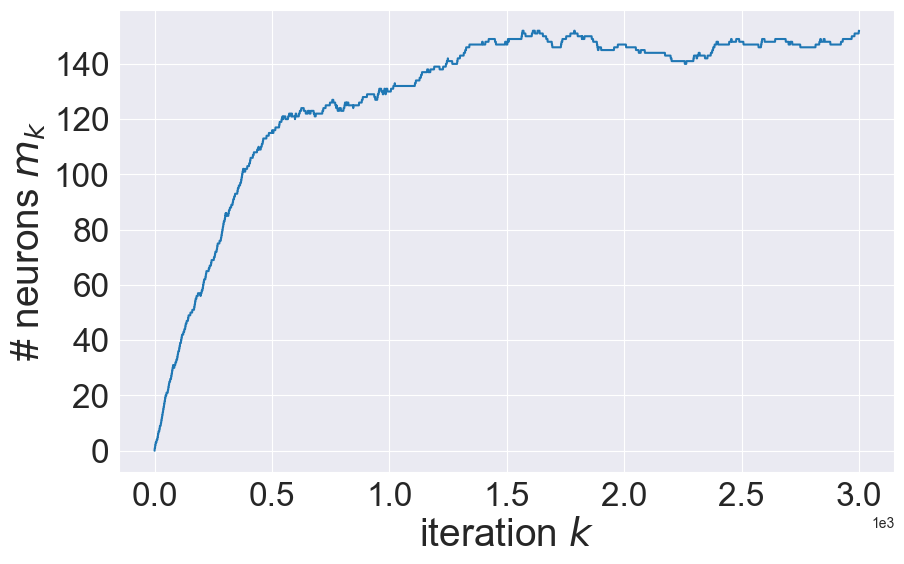

In [51]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms_mix)), ms_mix, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

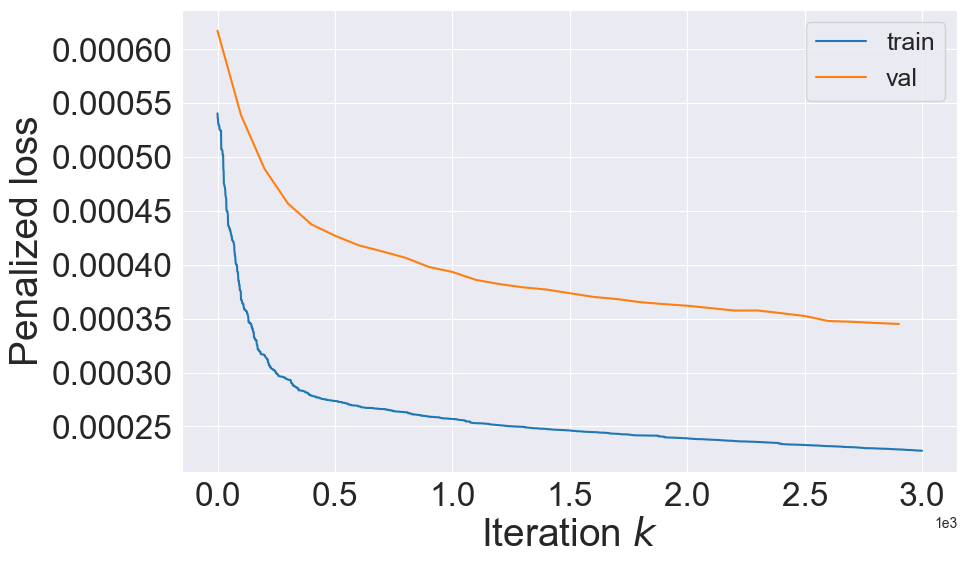

In [52]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_mix)), penalized_train_losses_mix, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

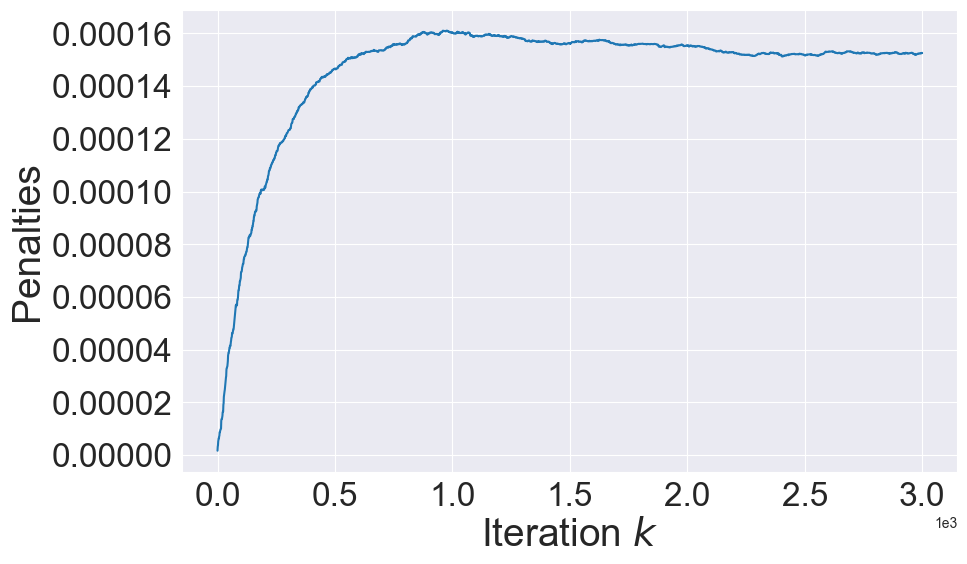

In [53]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_mix - train_losses_mix

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

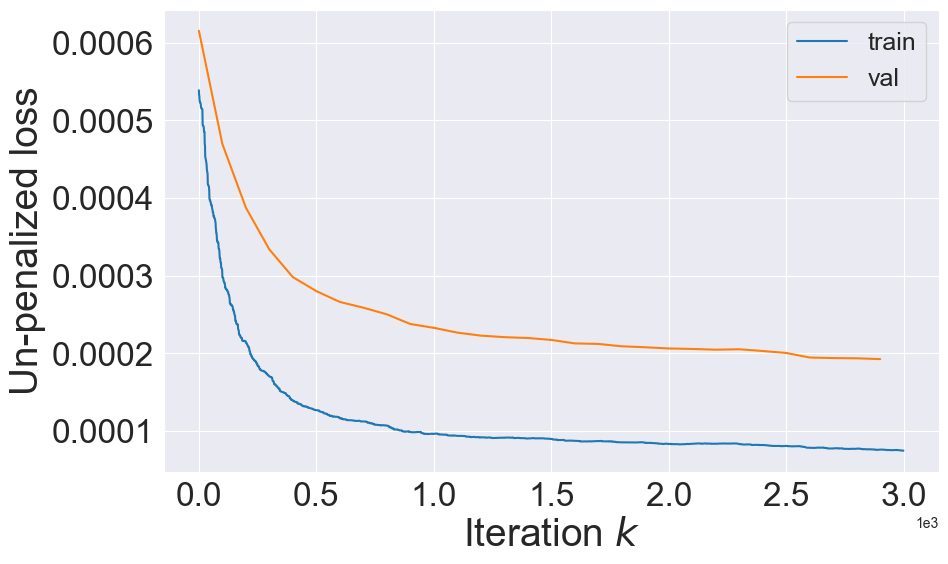

In [54]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_mix)), train_losses_mix, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_mix)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 5. Mix $L^2(\tau)/L^2(\tau_m)/\text{conic-GD}$ algorithm

In [55]:
n_steps = N_STEPS
m = 500
ALPHA = 1.0
BETA = 1.0
ETA = 0.01
penalized = True

In [56]:
def update_random_neuron(a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=a.shape[1])
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)

        if np.abs(new_a) > 0:
            # update weight for neuron b_j
            a[0, j] = new_a  
        else:
            # remove a_j and b_j from the list
            a = np.column_stack((a[:, :j], a[:, j+1:]))
            b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [57]:
#def projected_conic_particle_update(a, b, x, y, penalized=False):
#    m = a.shape[1]
#    if m > 0:
#        #a = a - ETA * V_grad(a, b, x, y, b).reshape(1, -1) / m
#        #b = b - m * ETA * nabla_V_grad(a, b, x, y, factor=a)
#        a = a - ETA * V_grad(a, b, x, y, b).reshape(1, -1)
#        b = b - ETA * nabla_V_grad(a, b, x, y, factor=a)
#        
#        if penalized:
#            a = a - ETA * LAMBDA * np.sign(a)
#        
#        b_norms = np.linalg.norm(b, ord=2, axis=1, keepdims=True)
#        # a = a * b_norms.T
#        b = b / b_norms
#    return a, b

In [58]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True, penalized=False):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []

    for k in tqdm(range(n_steps)):
        if k % 3 == 0:
            # sample new particle and set weight
            a, b = add_new_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        elif k % 3 == 1:
            # update existing particle
            a, b = update_random_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        else:
            # do conic-GD update
            a, b = projected_conic_particle_update(a, b, x_train, y_train, penalized=penalized)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [59]:
a, b, ms_mix_conic, train_losses_mix_conic, penalized_train_losses_mix_conic, val_losses, penalized_val_losses = \
        train(n_steps, x_train, y_train, x_val, y_val, penalized=penalized)

 18%|██████▉                               | 543/3000 [00:00<00:00, 2746.31it/s]

m at step 0 : 1
Train loss at step 0 : 0.00055
Validation loss at step 0 : 0.00061
m at step 100 : 25
Train loss at step 100 : 0.00034
Validation loss at step 100 : 0.00051
m at step 200 : 43
Train loss at step 200 : 0.00026
Validation loss at step 200 : 0.00045
m at step 300 : 55
Train loss at step 300 : 0.00022
Validation loss at step 300 : 0.00040
m at step 400 : 70
Train loss at step 400 : 0.00019
Validation loss at step 400 : 0.00036
m at step 500 : 85
Train loss at step 500 : 0.00016
Validation loss at step 500 : 0.00032


 40%|██████████████▋                      | 1191/3000 [00:00<00:00, 2864.15it/s]

m at step 600 : 92
Train loss at step 600 : 0.00015
Validation loss at step 600 : 0.00031
m at step 700 : 101
Train loss at step 700 : 0.00014
Validation loss at step 700 : 0.00029
m at step 800 : 109
Train loss at step 800 : 0.00013
Validation loss at step 800 : 0.00028
m at step 900 : 114
Train loss at step 900 : 0.00012
Validation loss at step 900 : 0.00027
m at step 1,000 : 117
Train loss at step 1,000 : 0.00011
Validation loss at step 1,000 : 0.00026
m at step 1,100 : 121
Train loss at step 1,100 : 0.00011
Validation loss at step 1,100 : 0.00025
m at step 1,200 : 126
Train loss at step 1,200 : 0.00010
Validation loss at step 1,200 : 0.00024


 58%|█████████████████████▌               | 1745/3000 [00:00<00:00, 2610.15it/s]

m at step 1,300 : 132
Train loss at step 1,300 : 0.00009
Validation loss at step 1,300 : 0.00024
m at step 1,400 : 131
Train loss at step 1,400 : 0.00009
Validation loss at step 1,400 : 0.00024
m at step 1,500 : 133
Train loss at step 1,500 : 0.00009
Validation loss at step 1,500 : 0.00023
m at step 1,600 : 134
Train loss at step 1,600 : 0.00009
Validation loss at step 1,600 : 0.00023
m at step 1,700 : 134
Train loss at step 1,700 : 0.00009
Validation loss at step 1,700 : 0.00022


 67%|████████████████████████▊            | 2009/3000 [00:00<00:00, 2376.09it/s]

m at step 1,800 : 133
Train loss at step 1,800 : 0.00008
Validation loss at step 1,800 : 0.00022
m at step 1,900 : 132
Train loss at step 1,900 : 0.00008
Validation loss at step 1,900 : 0.00022
m at step 2,000 : 132
Train loss at step 2,000 : 0.00008
Validation loss at step 2,000 : 0.00022
m at step 2,100 : 130
Train loss at step 2,100 : 0.00008
Validation loss at step 2,100 : 0.00021
m at step 2,200 : 128
Train loss at step 2,200 : 0.00008
Validation loss at step 2,200 : 0.00021
m at step 2,300 : 129
Train loss at step 2,300 : 0.00008
Validation loss at step 2,300 : 0.00021


100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 2895.36it/s]

m at step 2,400 : 129
Train loss at step 2,400 : 0.00008
Validation loss at step 2,400 : 0.00021
m at step 2,500 : 132
Train loss at step 2,500 : 0.00008
Validation loss at step 2,500 : 0.00021
m at step 2,600 : 132
Train loss at step 2,600 : 0.00008
Validation loss at step 2,600 : 0.00021
m at step 2,700 : 131
Train loss at step 2,700 : 0.00007
Validation loss at step 2,700 : 0.00021
m at step 2,800 : 132
Train loss at step 2,800 : 0.00007
Validation loss at step 2,800 : 0.00020
m at step 2,900 : 130
Train loss at step 2,900 : 0.00007
Validation loss at step 2,900 : 0.00020


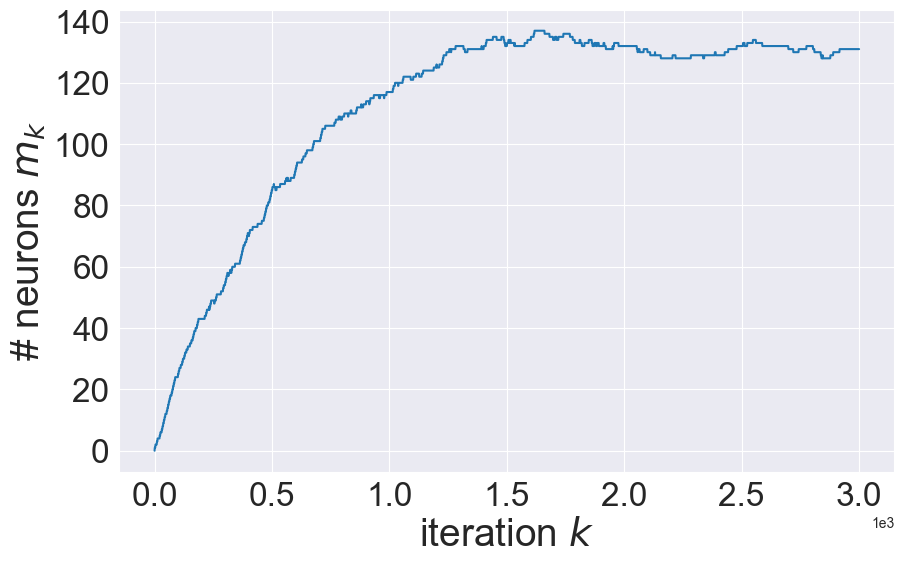

In [60]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms_mix_conic)), ms_mix_conic, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

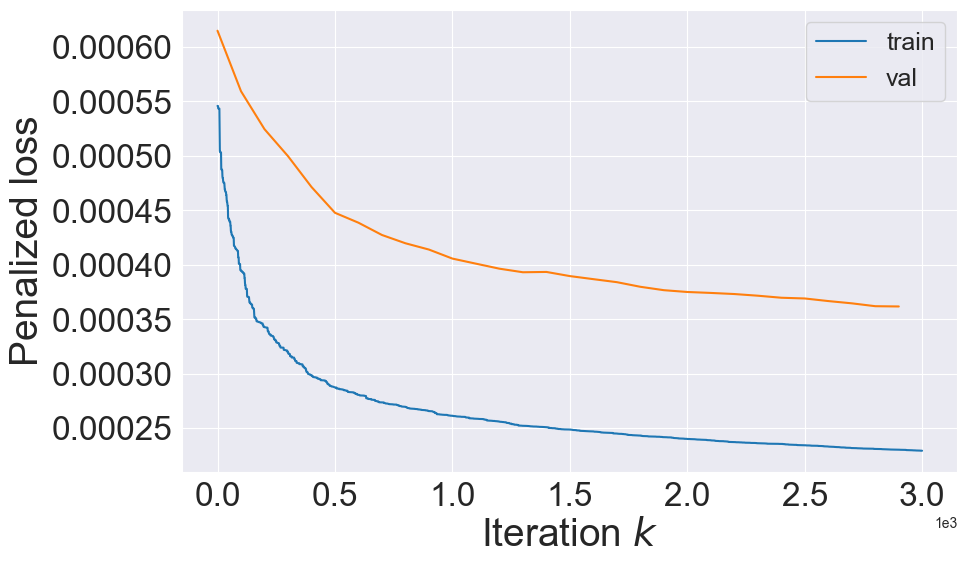

In [61]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix_conic)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

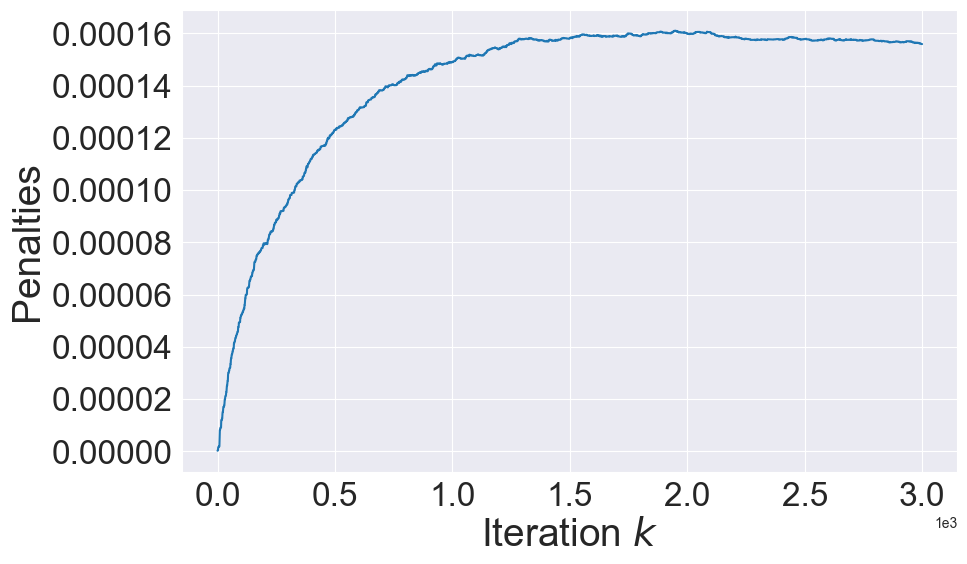

In [62]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_mix_conic - train_losses_mix_conic

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

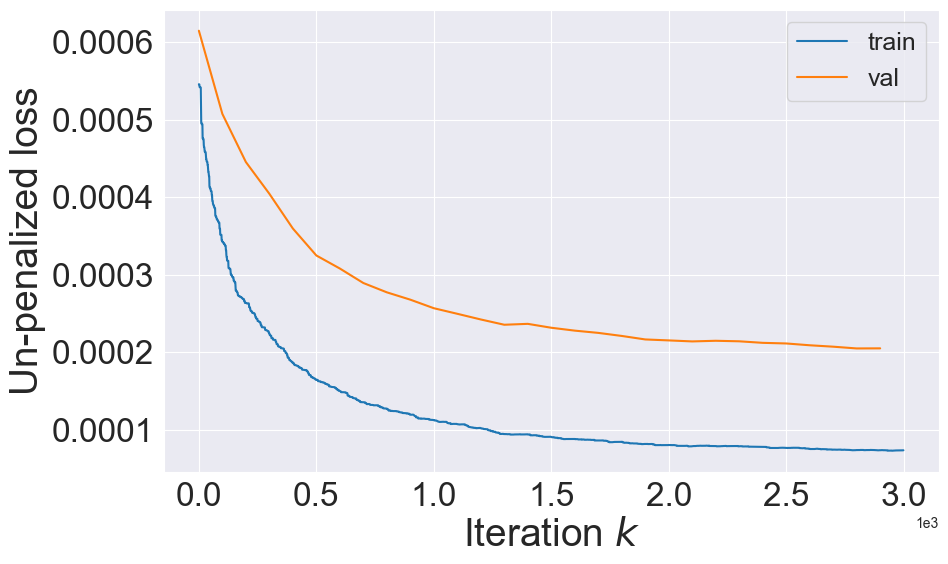

In [63]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_mix_conic)), train_losses_mix_conic, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_mix_conic)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 6. Comparative results

In [64]:
len(penalized_train_losses_pure_pop)

3000

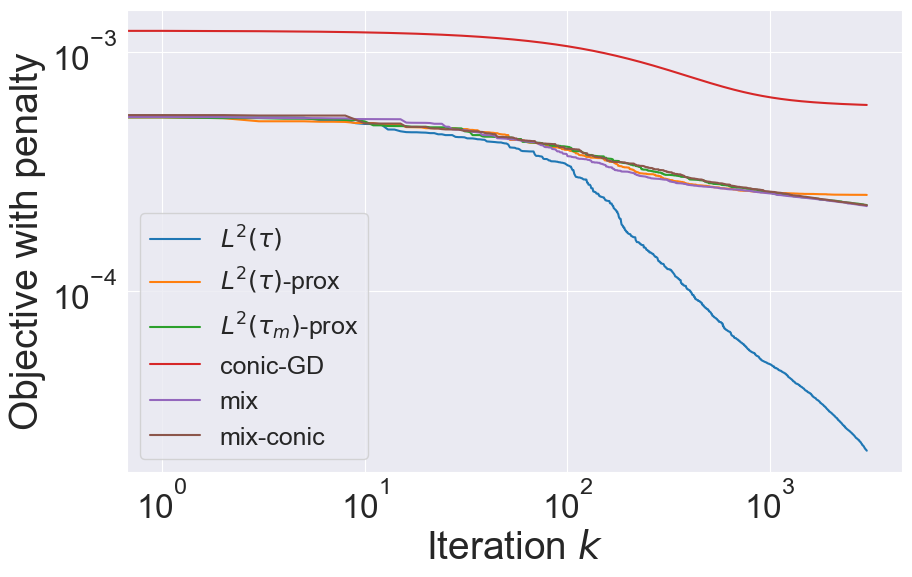

In [65]:
plt.figure(figsize=(10, 6))
marker = None #'o'
plt.xscale('log')
plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_pure_pop)), penalized_train_losses_pure_pop, label='$L^2(\\tau)$')
plt.plot(np.arange(len(penalized_train_losses_pop)), penalized_train_losses_pop, label='$L^2(\\tau)$-prox')
plt.plot(np.arange(len(penalized_train_losses_coord)), penalized_train_losses_coord, label='$L^2(\\tau_m)$-prox')
plt.plot(np.arange(len(penalized_train_losses_conic)), penalized_train_losses_conic, label='conic-GD')
plt.plot(np.arange(len(penalized_train_losses_mix)), penalized_train_losses_mix, label='mix')
plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='mix-conic')
#plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
#         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective with penalty', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'all_objectives_penalty_m={}.png'.format(m_star)), bbox_inches='tight')
plt.show()

In [66]:
colors = sns.color_palette()

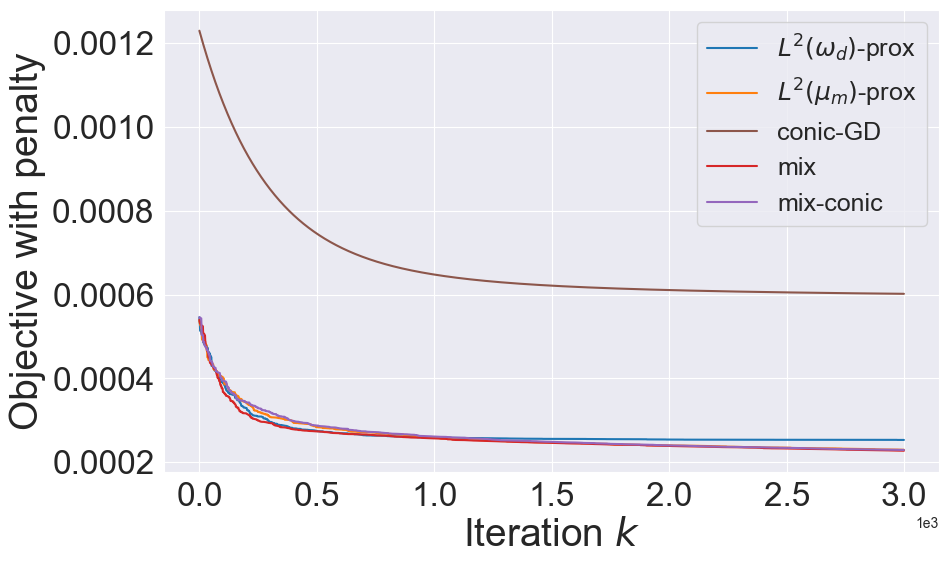

In [67]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

#plt.plot(np.arange(len(penalized_train_losses_pure_pop)), penalized_train_losses_pure_pop, label='$L^2(\\tau)$')
plt.plot(np.arange(len(penalized_train_losses_pop)), penalized_train_losses_pop, label='$L^2(\\omega_d)$-prox',
         color=colors[0])
plt.plot(np.arange(len(penalized_train_losses_coord)), penalized_train_losses_coord, label='$L^2(\\mu_m)$-prox',
         color=colors[1])
plt.plot(np.arange(len(penalized_train_losses_conic)), penalized_train_losses_conic, label='conic-GD',
         color=colors[5])
plt.plot(np.arange(len(penalized_train_losses_mix)), penalized_train_losses_mix, label='mix',
         color=colors[3])
plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='mix-conic',
         color=colors[4])
#plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
#         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective with penalty', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'pop_all_objectives_penalty_m={}.png'.format(m_star)), bbox_inches='tight')
plt.show()

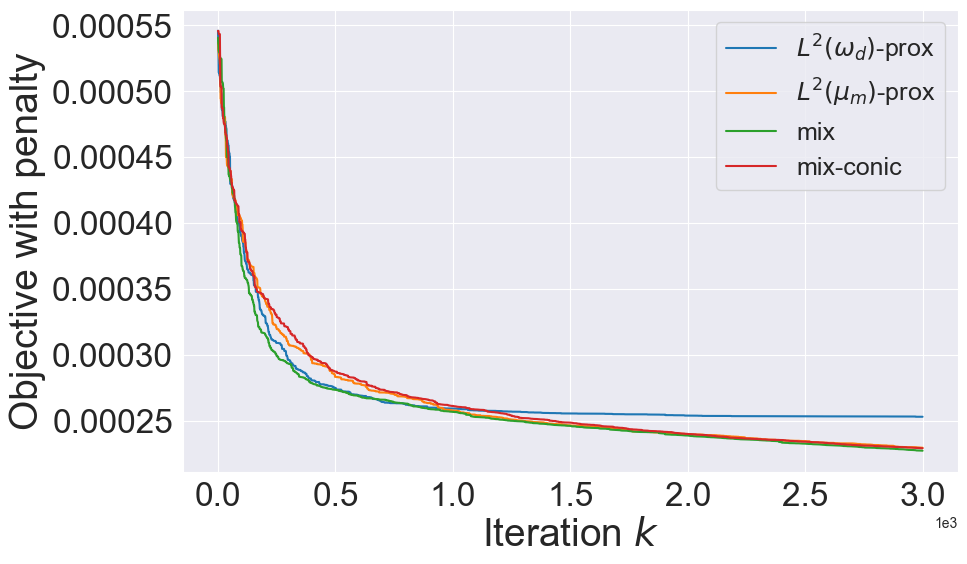

In [68]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

#plt.plot(np.arange(len(penalized_train_losses_pure_pop)), penalized_train_losses_pure_pop, label='$L^2(\\tau)$')
plt.plot(np.arange(len(penalized_train_losses_pop)), penalized_train_losses_pop, label='$L^2(\\omega_d)$-prox',
         color=colors[0])
plt.plot(np.arange(len(penalized_train_losses_coord)), penalized_train_losses_coord, label='$L^2(\\mu_m)$-prox',
         color=colors[1])
#plt.plot(np.arange(len(penalized_train_losses_conic)), penalized_train_losses_conic, label='conic-GD')
plt.plot(np.arange(len(penalized_train_losses_mix)), penalized_train_losses_mix, label='mix',
         color=colors[2])
plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='mix-conic',
         color=colors[3])
#plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
#         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective with penalty', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'all_objectives_penalty_m={}.png'.format(m_star)), bbox_inches='tight')
plt.show()

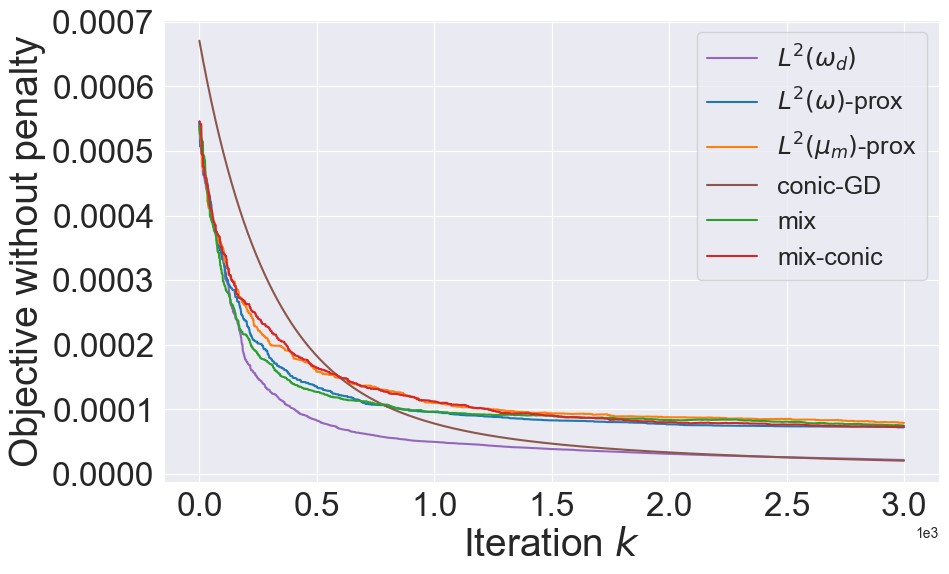

In [69]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_pure_pop)), train_losses_pure_pop, label='$L^2(\\omega_d)$',
         color=colors[4])
plt.plot(np.arange(len(train_losses_pop)), train_losses_pop, label='$L^2(\\omega)$-prox',
         color=colors[0])
plt.plot(np.arange(len(train_losses_coord)), train_losses_coord, label='$L^2(\\mu_m)$-prox',
         color=colors[1])
plt.plot(np.arange(len(train_losses_conic)), train_losses_conic, label='conic-GD',
         color=colors[5])
plt.plot(np.arange(len(train_losses_mix)), train_losses_mix, label='mix',
         color=colors[2])
plt.plot(np.arange(len(train_losses_mix_conic)), train_losses_mix_conic, label='mix-conic',
         color=colors[3])
#plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
#         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective without penalty', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'all_objectives_no_penalty_m={}.png'.format(m_star)), bbox_inches='tight')
plt.show()

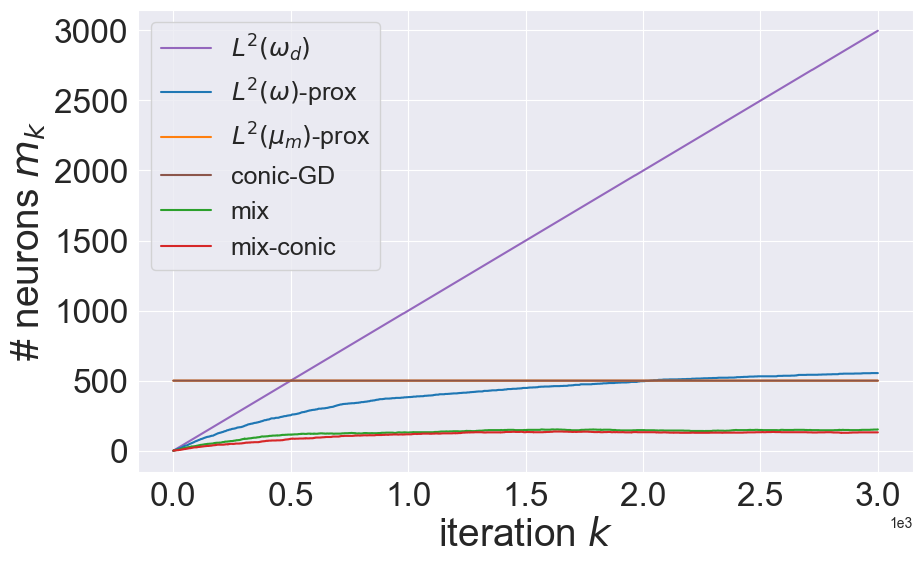

In [70]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms_pure_pop)), ms_pure_pop, label='$L^2(\\omega_d)$',
         color=colors[4])
plt.plot(np.arange(len(ms_pop)), ms_pop, label='$L^2(\\omega)$-prox',
         color=colors[0])
plt.plot(np.arange(len(ms_coord)), ms_coord, label='$L^2(\\mu_m)$-prox',
         color=colors[1])
plt.plot(np.arange(len(ms_conic)), ms_conic, label='conic-GD',
         color=colors[5])
plt.plot(np.arange(len(ms_mix)), ms_mix, label='mix',
         color=colors[2])
plt.plot(np.arange(len(ms_mix_conic)), ms_mix_conic, label='mix-conic',
         color=colors[3])

plt.legend(fontsize=18)

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'n_neurons_all.png'), bbox_inches='tight')
plt.show()

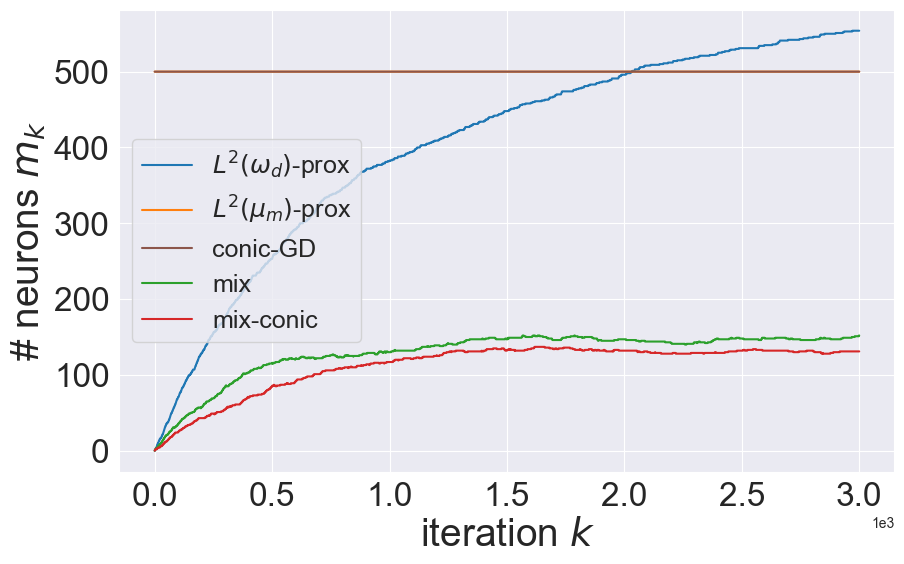

In [71]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

#plt.plot(np.arange(len(ms_pure_pop)), ms_pure_pop, label='$L^2(\\omega)$')
plt.plot(np.arange(len(ms_pop)), ms_pop, label='$L^2(\\omega_d)$-prox',
         color=colors[0])
plt.plot(np.arange(len(ms_coord)), ms_coord, label='$L^2(\\mu_m)$-prox',
         color=colors[1])
plt.plot(np.arange(len(ms_conic)), ms_conic, label='conic-GD',
         color=colors[5])
plt.plot(np.arange(len(ms_mix)), ms_mix, label='mix',
         color=colors[2])
plt.plot(np.arange(len(ms_mix_conic)), ms_mix_conic, label='mix-conic',
         color=colors[3])

plt.legend(fontsize=18)

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'n_neurons.png'), bbox_inches='tight')
plt.show()

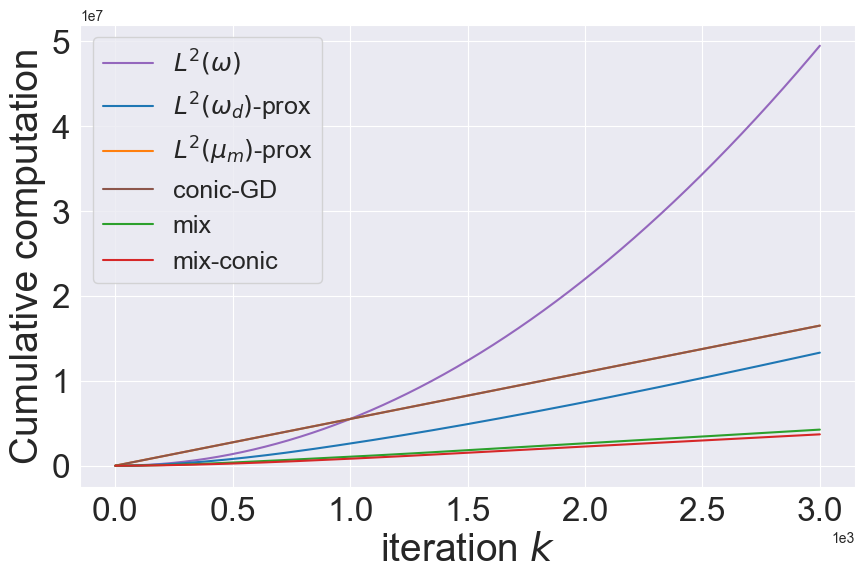

In [72]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms_pure_pop)), np.cumsum(ms_pure_pop) * (INPUT_DIM+1), label='$L^2(\\omega)$',
         color=colors[4])
plt.plot(np.arange(len(ms_pop)), np.cumsum(ms_pop) * (INPUT_DIM+1), label='$L^2(\\omega_d)$-prox',
         color=colors[0])
plt.plot(np.arange(len(ms_coord)), np.cumsum(ms_coord) * (INPUT_DIM+1), label='$L^2(\\mu_m)$-prox',
         color=colors[1])
plt.plot(np.arange(len(ms_conic)), np.cumsum(ms_conic) * (INPUT_DIM+1), label='conic-GD',
         color=colors[5])
plt.plot(np.arange(len(ms_mix)), np.cumsum(ms_mix) * (INPUT_DIM+1), label='mix',
         color=colors[2])
plt.plot(np.arange(len(ms_mix_conic)), np.cumsum(ms_mix_conic) * (INPUT_DIM+1), label='mix-conic',
         color=colors[3])

plt.legend(fontsize=18)

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('Cumulative computation', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'cumulative_complexity_all.png'), bbox_inches='tight')
plt.show()

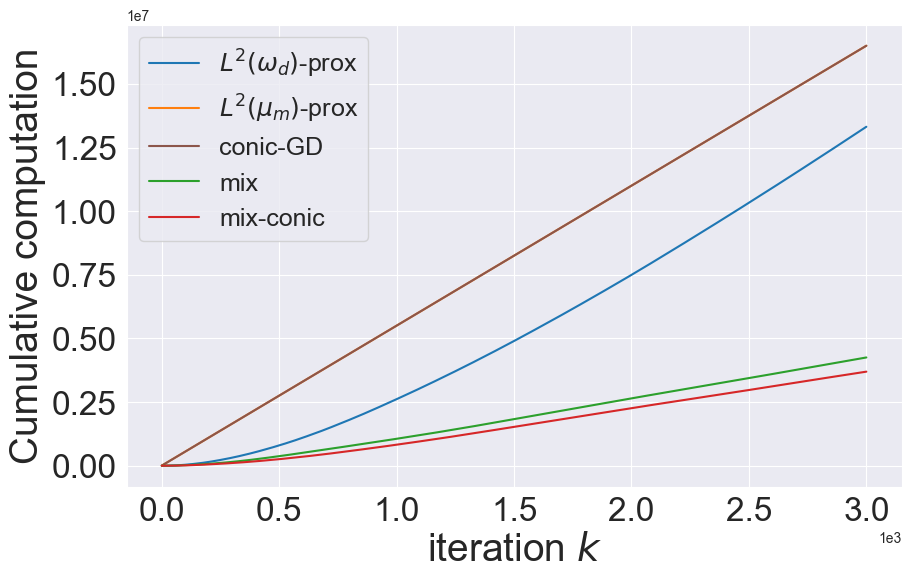

In [73]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

#plt.plot(np.arange(len(ms_pure_pop)), np.cumsum(ms_pure_pop), label='$L^2(\\omega)$',
#         color=colors[4])
plt.plot(np.arange(len(ms_pop)), np.cumsum(ms_pop) * (INPUT_DIM+1), label='$L^2(\\omega_d)$-prox',
         color=colors[0])
plt.plot(np.arange(len(ms_coord)), np.cumsum(ms_coord) * (INPUT_DIM+1), label='$L^2(\\mu_m)$-prox',
         color=colors[1])
plt.plot(np.arange(len(ms_conic)), np.cumsum(ms_conic) * (INPUT_DIM+1), label='conic-GD',
         color=colors[5])
plt.plot(np.arange(len(ms_mix)), np.cumsum(ms_mix * (INPUT_DIM+1)), label='mix',
         color=colors[2])
plt.plot(np.arange(len(ms_mix_conic)), np.cumsum(ms_mix_conic) * (INPUT_DIM+1), label='mix-conic',
         color=colors[3])

plt.legend(fontsize=18)

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('Cumulative computation', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'cumulative_complexity.png'), bbox_inches='tight')
plt.show()